In [6]:
import math
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from sklearn.manifold import MDS
from numpy import genfromtxt


In [7]:
# Rossler System
def Rossler(xi, t):
    a = 0.2
    b = 0.2
    c = 5.7
    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def RosslerP(xi, t, a, b, c):    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def Lorenz(xi,t):
    rho = 25.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def LorenzP(xi,t, rho, sigma, beta):
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def Lorenz96(x, t):
    N = 5 # dimension
    F = 8

    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d    

def LorenzYang(xi, t):
    k1 = lambda t : -0.01*(t**2)
    k2 = lambda t : 0.01*t
    k3 = lambda t : 0.01*t
    k4 = lambda t : -0.01*(t ** 2)

    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return -sigma*(x-y)+k1(t)*y, rho*x-y-x*z+k2(t)*z, -beta*z+x*y+(k3(t)+k4(t))*y  # Derivatives

def Sprott(xi, t):
    (x,y,z) = xi
    return ( y,-x - np.sign(z)*y, y**2 - np.exp(-x**2))

def SprottP(xi, t, d):
    (x,y,z) = xi
    return ( y, -x - np.sign(z)*y, y**2 - d*np.exp(-x**2))


In [8]:
def delayEmbed(Xin, Yin,assignment,embInterval):
    
    tmplen = Xin.shape[1]

    tmp = np.zeros([sum(x) for x in zip(Xin.shape,(0,sum(assignment)))])
    tmp[:,:Xin.shape[1]] = Xin
    Xin = tmp

    lag = 1
    newColInd = 0
    if len(assignment) != tmplen:
        print("Assigment list doesn't match the number of variables in data array! ",assignment)
        return
    else:
        # code that creates the lags
        for i in range(len(assignment)):
            for _ in range(assignment[i]):
                newCol = Xin[:-embInterval*lag,i]
                Xin[embInterval*lag:, tmplen + newColInd] = newCol
                newColInd += 1
                lag += 1
    Xin = Xin[embInterval*sum(assignment):]
    Yin = Yin[embInterval*sum(assignment):]
    
    # Yin = Yin[-X.shape[0]:]
    
    return (Xin, Yin)

# embedd with tuple of all variables as if each were a single variable
def delayEmbedUnitary(Xin, Yin, eD, eI):
    # eD - embedding dimension, eI - embedding Interval
    n = Xin.shape[0]
    
    if Xin.ndim == 1: # make sure flattened arrays are given 1 width dimension
        p = 1
        Xin = Xin.reshape((n,1))
    else:
        p = Xin.shape[1]
        
    Xout = np.zeros((n-eD*eI, p*(1+eD)))
    for ed in range(eD+1):
        Xout[:,ed*p:(ed+1)*p] = Xin[ed*eI:n-(eD-ed)*eI]
    Yout = Yin[eD*eI:]
    return (Xout, Yout)

In [9]:
# nearest neighbor prediction code

def nearestNeighbors(s0, S, n):
    orderedNeighbors = np.argsort(la.norm(s0 - S[:-1],axis=1))
    return orderedNeighbors[1:n+1]

# Lyapunov Edition
def lyapunovExp(S):
    Lexp = 0
    n = S.shape[0]-1
    for i in range(n):
        nearNeighborsIndices = nearestNeighbors(S[i], S, 1)
        for nni in nearNeighborsIndices:
            fprime = la.norm(S[i+1] - S[nni+1]) / la.norm(S[i] - S[nni])
            Lexp += np.log(fprime) # / la.norm(S[i] - S[nni])
    return Lexp / n # geometric mean - seems like lyapunov right?

# Proper Version
def fNearestNeighbors(S, nNeighbors):
    diff = 0
    for i in range(S.shape[0]-1):
        nearNeighborsIndices = nearestNeighbors(S[i], S, nNeighbors)
        # print("S0: {s1}, NS: {s2}".format(s1=S[i],s2=S[nearNeighborsIndices]))
        for nni in nearNeighborsIndices:
            diff += la.norm(S[i+1] - S[nni+1]) / la.norm(S[i] - S[nni])
    avgDiff = diff / ((S.shape[0]-1) * nNeighbors) # geometric mean - seems like lyapunov right?
    
    return avgDiff
    
def PMF1D(t, n):
    l = t.shape[0]
    m = np.min(t)
    r = np.ptp(t)  # range of data
    
    w = r / n # width of each bar
    h = np.zeros(n)# histogram
    
    for i in range(l):
        hi = int(np.floor((t[i]-m) / w))
        if hi == n:
            hi -= 1
        h[hi] += 1
    
    return h / l
    
def PMF2D(t1, t2, n):
    l1 = t1.shape[0] # get lengths of vectors
    l2 = t2.shape[0]
    if l1 != l2:
        raise Exception("time series aren't of the same length!")
    
    w1 = np.ptp(t1) / n # width of bars
    w2 = np.ptp(t2) / n
    
    m1 = np.min(t1) # minimums
    m2 = np.min(t2)
    
    h = np.zeros((n, n))
    
    for i in range(l1):
        hi1 = int(np.floor(( t1[i] - m1) / w1))
        hi2 = int(np.floor(( t2[i] - m2) / w2))
        if hi1 == n:
            hi1 -= 1
        if hi2 == n:
            hi2 -= 1
        h[hi1, hi2] += 1
            
    return h / l1

def mutualInformation(t1, t2, p):
    mI = 0
    
    pX = PMF1D(t1, p)
    pY = PMF1D(t2, p)
    pXY = PMF2D(t1, t2, p)
    for i1 in range(p):
        for i2 in range(p):
            if pXY[i1,i2] != 0:
                if pX[i1] == 0 or pY[i2] == 0:
                    print("Joint:{j} X:{x} Y:{y}".format(j=pXY[i1,i2],x=pX[i1],y=pY[i2]))
                mI += pXY[i1,i2] * np.log(pXY[i1,i2] / (pX[i1] * pY[i2]) )
                
    return mI / np.log(p) 

In [84]:
end = 2**6
tlen = 2 ** 10
print("Stepsize = {st}".format(st=end/tlen))
trainToTest = 0.5 # between 0 and 1
t = np.linspace(0, end, num=tlen)

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 3
ndrivers = 1
# t0 = np.array([0.5])
t0 = np.ones(dim) * 0.3333 # np.array([0,5,15]) * 1 # np.zeros(dim)
t0[0] += 0.1

Stepsize = 0.0625


In [85]:
# STATIONARY SIMULATION VERSION: UPDATE ATTRACTOR YOU WANT HERE
#               \/\/\/\/
# Xr = odeint(Lorenz,t0,t)

# NON STATIONARY VERSION

# Lorenz
rho = lambda t : 28 # + 2* (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1)) #np.sin(np.sqrt(2)/3*2*np.pi*t/tlen) + 4*np.sin(1.687/7*2*np.pi*t/tlen)  # rho = 28.0
# sigma = 10       # sigma = 10.0
sigma = lambda t : 10.0 + np.cos(1/2*2*np.pi * t / (tlen-2))
beta = lambda t : 8.0 / 3.0  # beta = 8.0 / 3.0

largs = lambda t : (rho(t), sigma(t), beta(t))

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(LorenzP,states[i-1],np.array([t[i-1],t[i]]),args=largs(i))[1,:]
Xr = states
"""
# Rossler
ap = lambda t : 0.2 + 0.1 * (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1)) # 0.1 * np.sin(1.68/4*2*np.pi*t/tlen)-0.05*np.cos(0.25*2*np.pi*t/tlen) # rho = 28.0
# sigma = 10       # sigma = 10.0
bp = lambda t : 0.2 + 0.1 * np.sin( 0.75 * 2*np.pi * t / (tlen-2))
cp = lambda t : 5.7 # beta = 8.0 / 3.0

largs = lambda t : (ap(t), bp(t), cp(t))

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(RosslerP,states[i-1],t[i-1:i+1],args=largs(i))[1,:]
Xr = states
"""
"""
# Sprott 
dp = lambda t : 0.5 + 0.5 * t / tlen

largs = lambda t : (dp(t),)

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(SprottP,states[i-1],t[i-1:i+1],args=largs(i))[1,:]
Xr = states
"""

# END NON STATIONARY

'\n# Sprott \ndp = lambda t : 0.5 + 0.5 * t / tlen\n\nlargs = lambda t : (dp(t),)\n\nstates = np.zeros((tlen,3))\nstates[0] = t0\nfor i in range(1, tlen ):\n    # print(largs(i))\n    states[i] = odeint(SprottP,states[i-1],t[i-1:i+1],args=largs(i))[1,:]\nXr = states\n'

In [86]:
# PMF testing
"""
res = 20

jsaf = PMF1D(Xr[:,0],res) 
# print(jsaf.shape, jsaf)

fhist, axhist = plt.subplots(4,figsize=(12, 8*3))
axhist[0].plot(jsaf)
axhist[1].hist(Xr[:,0], bins=res)

test2 = PMF2D(Xr[:,0], Xr[:,1], res)
axhist[2].imshow(test2)

mIT = np.zeros((20,3))
for i in range(mIT.shape[0]):
    nhist = i ** 2 + 1
    
    print(nhist, " done.")
    mIT[i,0] = mutualInformation(Xr[:,0], Xr[:,1], nhist)
    mIT[i,1] = mutualInformation(Xr[:,1], Xr[:,2], nhist)
    mIT[i,2] = mutualInformation(Xr[:,2], Xr[:,0], nhist)

axhist[3].plot(mIT[:,0])
axhist[3].plot(mIT[:,1])
axhist[3].plot(mIT[:,2])

# Weird, seems that increasing groupings increases mutual information score. Don't know if that should be expected or not

plt.show()
"""

'\nres = 20\n\njsaf = PMF1D(Xr[:,0],res) \n# print(jsaf.shape, jsaf)\n\nfhist, axhist = plt.subplots(4,figsize=(12, 8*3))\naxhist[0].plot(jsaf)\naxhist[1].hist(Xr[:,0], bins=res)\n\ntest2 = PMF2D(Xr[:,0], Xr[:,1], res)\naxhist[2].imshow(test2)\n\nmIT = np.zeros((20,3))\nfor i in range(mIT.shape[0]):\n    nhist = i ** 2 + 1\n    \n    print(nhist, " done.")\n    mIT[i,0] = mutualInformation(Xr[:,0], Xr[:,1], nhist)\n    mIT[i,1] = mutualInformation(Xr[:,1], Xr[:,2], nhist)\n    mIT[i,2] = mutualInformation(Xr[:,2], Xr[:,0], nhist)\n\naxhist[3].plot(mIT[:,0])\naxhist[3].plot(mIT[:,1])\naxhist[3].plot(mIT[:,2])\n\n# Weird, seems that increasing groupings increases mutual information score. Don\'t know if that should be expected or not\n\nplt.show()\n'

In [87]:
# Composition Function
"""
def compFunc(t):
    a = 3
    b = 5 ** -1
    c = 1.61803398875
    return np.sin(t/c)+np.sin(t / a + np.pi / 2.0) + b

Xr = np.fromfunction(lambda i, j: compFunc(i), (tlen,1))
print(Xr)
"""

'\ndef compFunc(t):\n    a = 3\n    b = 5 ** -1\n    c = 1.61803398875\n    return np.sin(t/c)+np.sin(t / a + np.pi / 2.0) + b\n\nXr = np.fromfunction(lambda i, j: compFunc(i), (tlen,1))\nprint(Xr)\n'

In [88]:
# Logistic Map
"""
r = lambda t : 3.35 + 0.6 * np.sin(0.7*2*np.pi*t/tlen)
# r = lambda t : 0.5 * t / tlen + 3.5
states = np.zeros((tlen,1))
states[0,0] = t0
for t in range(1,tlen):
    states[t,0] = r(t) * states[t-1,0] * (1 - states[t-1,0])
Xr = states
"""
"""
# Density Dependent Maturation
states = np.ones((tlen, 2))
s = 0.02
gamma = 0.01
sA = 0.1
sJ = 0.5
b = 35
# Gmax = 0.9
# g = lambda x : Gmax*np.exp(-gamma*x)
# Gmax = lambda t : 0.25 + t * 0.74 / (tlen-2) # LINEAR GMAX
# Gmax = lambda t : 0.75 + 0.25 * np.sin( 4 * 2 * np.pi * t / (tlen-2)) # PERIODIC
Gmax = lambda t : 0.75
g = lambda x , t: Gmax(t)*np.exp(-gamma*x)
states[0] = np.array([5,300])
for i in range(0,tlen-1):
    At = states[i,0]
    Jt = states[i,1]
    zt = rand.normal(-s/2, s) # rand.normal(0,s) # vs rand.normal(-(s**2)/2, s)
    # m = np.array([[sA, sJ*g(At+Jt)],[b*np.exp(zt), sJ*(1-g(At+Jt))]])
    m = np.array([[sA, sJ*g(At+Jt,i)],[b*np.exp(zt), sJ*(1-g(At+Jt,i))]])
    states[i+1] = m @ states[i].T
Xr = states


# Generic Linear System
alpha = 1e-1
A = np.array([[np.cos(alpha), np.sin(alpha)],[-np.sin(alpha), np.cos(alpha)]])

states = np.ones((tlen, 2))
for i in range(tlen-1):
    states[i+1] = states[i] @ A 

Xr = states
print(Xr)
"""

'\n# Density Dependent Maturation\nstates = np.ones((tlen, 2))\ns = 0.02\ngamma = 0.01\nsA = 0.1\nsJ = 0.5\nb = 35\n# Gmax = 0.9\n# g = lambda x : Gmax*np.exp(-gamma*x)\n# Gmax = lambda t : 0.25 + t * 0.74 / (tlen-2) # LINEAR GMAX\n# Gmax = lambda t : 0.75 + 0.25 * np.sin( 4 * 2 * np.pi * t / (tlen-2)) # PERIODIC\nGmax = lambda t : 0.75\ng = lambda x , t: Gmax(t)*np.exp(-gamma*x)\nstates[0] = np.array([5,300])\nfor i in range(0,tlen-1):\n    At = states[i,0]\n    Jt = states[i,1]\n    zt = rand.normal(-s/2, s) # rand.normal(0,s) # vs rand.normal(-(s**2)/2, s)\n    # m = np.array([[sA, sJ*g(At+Jt)],[b*np.exp(zt), sJ*(1-g(At+Jt))]])\n    m = np.array([[sA, sJ*g(At+Jt,i)],[b*np.exp(zt), sJ*(1-g(At+Jt,i))]])\n    states[i+1] = m @ states[i].T\nXr = states\n\n\n# Generic Linear System\nalpha = 1e-1\nA = np.array([[np.cos(alpha), np.sin(alpha)],[-np.sin(alpha), np.cos(alpha)]])\n\nstates = np.ones((tlen, 2))\nfor i in range(tlen-1):\n    states[i+1] = states[i] @ A \n\nXr = states\nprint(Xr)

In [89]:
"""
file = "Gross Earnings Salmon Summary By AREA.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
print(data.info())

# Xr = data["Year"].drop_duplicates().reset_index(drop=True)
# years = Xr.copy()
# print(Xr)
years = data["Year"].drop_duplicates().reset_index(drop=True)

data.drop(["Estimated Exvessel Value (Nominal)","Landed Weight (lbs)","Region"],1,inplace=True)
data.set_index(["Salmon Area Name","Species Code", "Year"],inplace=True)
data.replace("", np.nan, inplace=True)
data.dropna(inplace=True)

# figDr, axDr = plt.subplots(figsize)
"""

'\nfile = "Gross Earnings Salmon Summary By AREA.csv"\ndata = pd.read_csv(file,encoding="utf-8",na_filter=False)\nprint(data.info())\n\n# Xr = data["Year"].drop_duplicates().reset_index(drop=True)\n# years = Xr.copy()\n# print(Xr)\nyears = data["Year"].drop_duplicates().reset_index(drop=True)\n\ndata.drop(["Estimated Exvessel Value (Nominal)","Landed Weight (lbs)","Region"],1,inplace=True)\ndata.set_index(["Salmon Area Name","Species Code", "Year"],inplace=True)\ndata.replace("", np.nan, inplace=True)\ndata.dropna(inplace=True)\n\n# figDr, axDr = plt.subplots(figsize)\n'

In [90]:
"""
print(data.index.levels[1])
dataX = data.xs("Pink",level="Species Code")

nloc = len(dataX.index.levels[0])
# nspec = len(dataX.index.levels[1])
# print(nloc, nspec)

arr = np.zeros((len(years),nloc))

print(dataX.index.levels)
print(dataX.index.levels)
for l in range(nloc):
    # for s in range(nspec):
    for y in range(len(years)):
        location = dataX.index.levels[0][l]
        # species = dataX.index.levels[1][s]
        # if (location, species, years[y]) in dataX.index:
        if (location, years[y]) in dataX.index:
            # arr[y, l*nspec+s] = dataX.loc[(location, years[y])]
            arr[y, l] = dataX.loc[(location, years[y])]
            
# arr = dataX.reset_index().to_numpy()
# print(arr)
# conclusion : fuck pandas, terrible terrible piece of software

# standardize data so less numerical instability
Xr = (arr - np.mean(arr,axis=0))/ np.std(arr,axis=0)

#Xr = np.delete(Xr, [25,27,28,29,33,35,36,38,39,53,54],1)

print(Xr.shape)
"""

'\nprint(data.index.levels[1])\ndataX = data.xs("Pink",level="Species Code")\n\nnloc = len(dataX.index.levels[0])\n# nspec = len(dataX.index.levels[1])\n# print(nloc, nspec)\n\narr = np.zeros((len(years),nloc))\n\nprint(dataX.index.levels)\nprint(dataX.index.levels)\nfor l in range(nloc):\n    # for s in range(nspec):\n    for y in range(len(years)):\n        location = dataX.index.levels[0][l]\n        # species = dataX.index.levels[1][s]\n        # if (location, species, years[y]) in dataX.index:\n        if (location, years[y]) in dataX.index:\n            # arr[y, l*nspec+s] = dataX.loc[(location, years[y])]\n            arr[y, l] = dataX.loc[(location, years[y])]\n            \n# arr = dataX.reset_index().to_numpy()\n# print(arr)\n# conclusion : fuck pandas, terrible terrible piece of software\n\n# standardize data so less numerical instability\nXr = (arr - np.mean(arr,axis=0))/ np.std(arr,axis=0)\n\n#Xr = np.delete(Xr, [25,27,28,29,33,35,36,38,39,53,54],1)\n\nprint(Xr.shape)\n'

In [91]:
# Read input data from files
"""
# file = "paramecium_didinium - cleaned.csv"
file = "Gross Earnings Salmon Summary By AREA.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
print(data.groupby(["Salmon Area Name", "Species Code"]))
#print(dataR.info())
data.fillna(0, inplace =True)
data.replace("",0,inplace=True)
data.drop(["Region","Landed Weight (lbs)","Estimated Exvessel Value (Nominal)"],1,inplace=True)
print(data.info())

dataLabels = data.iloc[:,[0,2]]
multiIndex = pd.MultiIndex.from_frame(dataLabels)

processedData = data["Year"].drop_duplicates()
years = processedData.copy()
# print(processedData)
nyears = processedData.shape[0]

#print("# of Years = ", nyears)
for location in multiIndex.levels[0]:
    for species in multiIndex.levels[1]:
        col = data[(data["Salmon Area Name"] == location) & (data["Species Code"] == species)]
        col.drop(["Salmon Area Name","Species Code"], inplace=True)
        colFull = years.copy()
        colFull["Number of Fish(estimated)"] = pd.Series(np.zeros(nyears))
        
        processedCol = col["Number of Fish (estimated)"]
        if processedCol.size != nyears:
            #print("ERROR {c} != {s}".format(c=nyears,s=processedCol.size))
            print(col)
        else:
            processedData["{loc}_{spec}".format(loc=location,spec=species)] = processedCol

# print(processedData)
# print(multiIndex)

X = data.to_numpy()
"""

'\n# file = "paramecium_didinium - cleaned.csv"\nfile = "Gross Earnings Salmon Summary By AREA.csv"\ndata = pd.read_csv(file,encoding="utf-8",na_filter=False)\nprint(data.groupby(["Salmon Area Name", "Species Code"]))\n#print(dataR.info())\ndata.fillna(0, inplace =True)\ndata.replace("",0,inplace=True)\ndata.drop(["Region","Landed Weight (lbs)","Estimated Exvessel Value (Nominal)"],1,inplace=True)\nprint(data.info())\n\ndataLabels = data.iloc[:,[0,2]]\nmultiIndex = pd.MultiIndex.from_frame(dataLabels)\n\nprocessedData = data["Year"].drop_duplicates()\nyears = processedData.copy()\n# print(processedData)\nnyears = processedData.shape[0]\n\n#print("# of Years = ", nyears)\nfor location in multiIndex.levels[0]:\n    for species in multiIndex.levels[1]:\n        col = data[(data["Salmon Area Name"] == location) & (data["Species Code"] == species)]\n        col.drop(["Salmon Area Name","Species Code"], inplace=True)\n        colFull = years.copy()\n        colFull["Number of Fish(estimated)

In [92]:
""" UPDATE DRIVERS HERE """
digiDrivers = [sigma]

gtsr = np.zeros((Xr.shape[0], ndrivers))
for ind in range(len(digiDrivers)):
    tmp = np.fromfunction(lambda i : digiDrivers[ind](i), (Xr.shape[0],) , dtype = float)# time series of gmax
    gtsr[:,ind] = tmp
    
""" DATA DRIVER """
"""
IPO = np.genfromtxt("IDPO.txt", delimiter= ",", dtype=float)
IPO = np.delete(IPO,range(0,125) ,0)
IPO = np.delete(IPO,0,1)
IPO = IPO.flatten()
IPO = IPO[:-6]

figIPO, axIPO = plt.subplots(4)
axIPO[0].plot(IPO)
axIPO[1].plot(IPO[::12][:Xr.shape[0]])
axIPO[2].plot(IPO[1::12][:Xr.shape[0]])
axIPO[3].plot(IPO[2::12][:Xr.shape[0]])

plt.show()

gtsr[:,0] = (IPO[::12])[:Xr.shape[0]]
gtsr[:,1] = (IPO[1::12])[:Xr.shape[0]]
gtsr[:,2] = (IPO[2::12])[:Xr.shape[0]]
# print(gtsr)
"""

'\nIPO = np.genfromtxt("IDPO.txt", delimiter= ",", dtype=float)\nIPO = np.delete(IPO,range(0,125) ,0)\nIPO = np.delete(IPO,0,1)\nIPO = IPO.flatten()\nIPO = IPO[:-6]\n\nfigIPO, axIPO = plt.subplots(4)\naxIPO[0].plot(IPO)\naxIPO[1].plot(IPO[::12][:Xr.shape[0]])\naxIPO[2].plot(IPO[1::12][:Xr.shape[0]])\naxIPO[3].plot(IPO[2::12][:Xr.shape[0]])\n\nplt.show()\n\ngtsr[:,0] = (IPO[::12])[:Xr.shape[0]]\ngtsr[:,1] = (IPO[1::12])[:Xr.shape[0]]\ngtsr[:,2] = (IPO[2::12])[:Xr.shape[0]]\n# print(gtsr)\n'

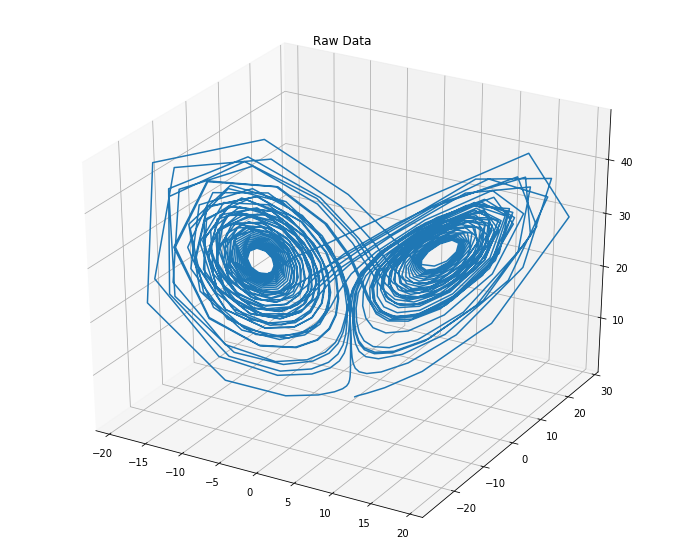

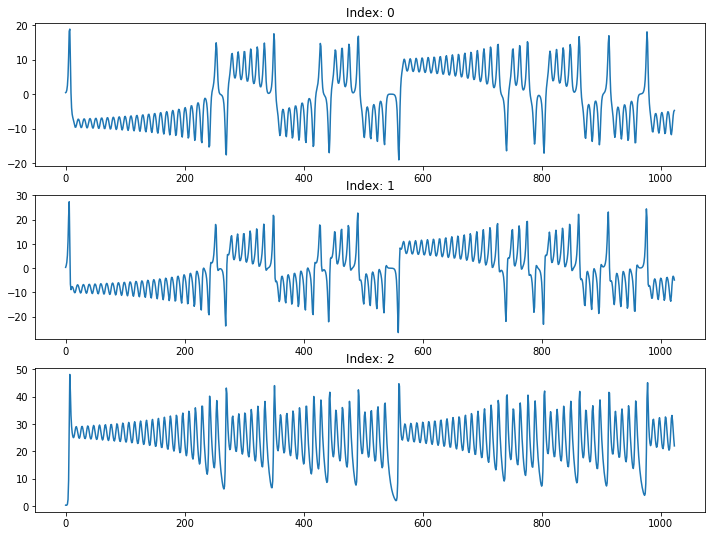

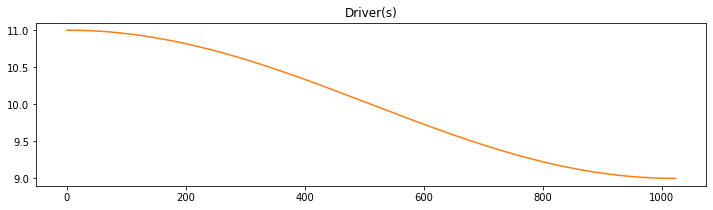

In [93]:
fig2 = plt.figure(2,figsize=(12,10))
if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],Xr[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2])
ax2.set_title("Raw Data")

""" OBSOLETE - just overembed with large step size, no need to cut things up after the fact.

figSliced = plt.figure(3)
# Sneakyness - only keep every 20th entry to test spikiness hypothesis
X = X[::]

if dim == 1:
    axSliced = plt.subplot()
    axSliced.plot(X[:,0],"b") # states
elif dim == 2:
    axSliced = plt.subplot()
    axSliced.plot(X[:,0],X[:,1])
else:
    axSliced = fig2.gca(projection="3d")
    axSliced.plot(X[:,0],X[:,1],X[:,2])
axSliced.set_title("Cut")
"""
if dim != 1:
    figTS, axTS = plt.subplots(dim,figsize=(12,dim*3))
    axTS[0].set_title("Cross section Time Series")
    for i in range(dim):
        axTS[i].set_title("Index: {ind}".format(ind=i))
        axTS[i].plot(Xr[:,i])

if ndrivers != 0:
    figD, axD = plt.subplots(ndrivers, figsize=(12,ndrivers*3))
    if ndrivers == 1:
        axD.set_title("Driver(s)")
        axD.plot(gtsr, c="tab:orange")
    else:
        axD[0].set_title("Driver(s)")
        for d in range(ndrivers):
            axD[d].plot(gtsr[:,d], c="tab:orange")
        
plt.show()

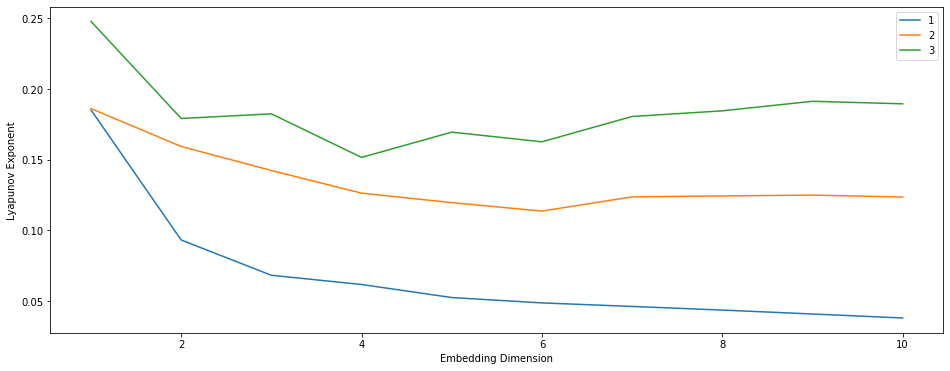

In [59]:
# False Nearest Neighbors Test

# Unitary Embedding Testing

l = 10
c = 1
st = 3

# figFNN, axFNN = plt.subplots(2 * c,figsize=(16, 3*(2*c)))
figFNN, axFNN = plt.subplots(c, figsize=(16, 6*c))
# figFNN = plt.figure(figsize=(12, 8))
# axFNN = figFNN.add_subplot()

for c in range(1, c+1):
    lyapExps = np.zeros(l)
    for s in range(1, st+1, 1):
        for i in range(1, l+1):
            Y, _ = delayEmbed(Xr[::c], Xr[::c], [i]*dim,s)
            # Y, _ = delayEmbedUnitary(Xr[::c], Xr[::c], i,s)
            lyapExps[i-1] = lyapunovExp(Y)
            
        axFNN.plot(range(1,l+1), lyapExps, label="{e}".format(e=s))

    axFNN.legend()
    axFNN.set_xlabel("Embedding Dimension")
    # axFNN[c-1].set_title("Slice = {ind}".format(ind=c))
    axFNN.set_ylabel("Lyapunov Exponent")
    
plt.show()

In [60]:
# Slice
# cut = 1
# X = Xr[::cut]
# tlen = int(np.floor(tlen / cut))

# Delay Embed
X, _ = delayEmbed(Xr, Xr, [3]*dim,1)
# X, _ = delayEmbedUnitary(Xr, Xr, 3,1) # << Seems to always suck, even though it should be better...

print(Xr.shape)
gtsr = standardize(gtsr[:X.shape[0]])
print(X.shape,gtsr.shape)

(1024, 3)
(1015, 12) (1015, 1)


In [61]:
# X = (X - X.mean(0) ) / X.std(0) # normalize
print(X, X.shape)

[[ -9.1025  -8.0883  29.0622 ...   2.4021   0.3453   0.3333]
 [ -7.6295  -6.8178  27.2208 ...  29.8011   2.4021   0.3453]
 [ -7.3274  -7.7249  25.0662 ...  41.5007  29.8011   2.4021]
 ...
 [ -3.1904  -7.0945  24.5733 ...   9.3162  13.0054  18.1609]
 [ -6.5718  -9.4116  21.9986 ...   6.6777   9.3162  13.0054]
 [ -9.935  -12.6305  25.929  ...   4.8325   6.6777   9.3162]] (1015, 12)


In [62]:
# Slow Feature Analysis

def hprime(x):
    n = x.shape[0]
    d = x.shape[1]
    
    M = int(d+d*(d+1)/2) + d # number of monomials and binomials
    
    hx = np.zeros((n,M))
    hx[:,0:d] = x
    ind = d
    for i in range(d):
        xi = x[:,i]
        for j in range(i,d):
            xj = x[:,j]
            hx[:,ind] = np.multiply(xi, xj)
            ind += 1
            
    hx[:,M-d:] = np.exp(x)
    
    print(hx)
            
    return hx

def standardize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

In [63]:
np.set_printoptions(precision=4, suppress=True)
Xst = standardize(X)

# U, S, V = la.svd(Xst)
# print("Singular Values({n}): {s}".format(n=len(S),s=S))


In [64]:
# Nonlinear Basis Expansion

zprime = Xst
# zprime = hprime(Xst)
print(zprime.shape)

(1015, 12)


In [65]:
# try SVD to reduce the dimensionality
"""
U, S, V = la.svd(zprime)

print(U.shape ,S.shape, V.shape)
prec = 15
# print(U[:,:prec], np.diag(S[:prec]), V[:prec,:].T)
Xrec = (U[:,:prec] * S[:prec]) @ V[:prec,:]
# Xrec = U[:,:prec] @ np.diag(S[:prec]) @ V[:prec,:]

zprimeR = U[:,:prec] * S[:prec]

print("Original and SVD Simplified Correlation = {corr}".format(corr=np.dot(zprime.flatten(),Xrec.flatten())/(la.norm(zprime)*la.norm(Xrec))))
# print("X original{xOs}: \n{xO}\nX SVD{xSVDs}: \n{xSVD}".format(xOs=Xst.shape,xO=Xst,xSVDs=Xred.shape,xSVD=Xred))
print("zprimeR reduced form = {red}".format(red=Xred.shape))
"""

'\nU, S, V = la.svd(zprime)\n\nprint(U.shape ,S.shape, V.shape)\nprec = 15\n# print(U[:,:prec], np.diag(S[:prec]), V[:prec,:].T)\nXrec = (U[:,:prec] * S[:prec]) @ V[:prec,:]\n# Xrec = U[:,:prec] @ np.diag(S[:prec]) @ V[:prec,:]\n\nzprimeR = U[:,:prec] * S[:prec]\n\nprint("Original and SVD Simplified Correlation = {corr}".format(corr=np.dot(zprime.flatten(),Xrec.flatten())/(la.norm(zprime)*la.norm(Xrec))))\n# print("X original{xOs}: \n{xO}\nX SVD{xSVDs}: \n{xSVD}".format(xOs=Xst.shape,xO=Xst,xSVDs=Xred.shape,xSVD=Xred))\nprint("zprimeR reduced form = {red}".format(red=Xred.shape))\n'

In [66]:
"""
# replace this with SVD?
c = np.cov(zprime.T, bias=False, rowvar=True)
# print("Covariance = ", c, c.shape)

eigval, eigvec = la.eigh(c)
# print("Eigenstuff = ", eigval, eigvec)
print("Eigenvals(shouldn't be near 0) ", eigval)

diagEigVal = np.diag((eigval+1e-7) ** -0.5)

print(zprime.shape, diagEigVal.shape, eigvec.T.shape)
z = zprime @ (eigvec @ diagEigVal)
# print("z = ", z)
print("Mean test(should be 0)", np.mean(z))
print("Covariance test(should be I): \n",np.cov(z.T))
"""

Eigenvals(shouldn't be near 0)  [0.0047 0.0145 0.0866 0.1566 0.1968 0.5199 0.656  1.0301 1.4453 1.6385
 1.7407 4.522 ]
(1015, 12) (12, 12) (12, 12)
Mean test(should be 0) -1.4350863136041434e-16
Covariance test(should be I): 
 [[ 1. -0.  0. -0.  0.  0. -0. -0. -0. -0.  0. -0.]
 [-0.  1.  0. -0. -0.  0. -0.  0. -0.  0. -0.  0.]
 [ 0.  0.  1. -0. -0. -0. -0. -0.  0.  0. -0.  0.]
 [-0. -0. -0.  1.  0.  0. -0. -0. -0. -0.  0. -0.]
 [ 0. -0. -0.  0.  1. -0.  0.  0.  0. -0.  0.  0.]
 [ 0.  0. -0.  0. -0.  1.  0.  0.  0. -0.  0. -0.]
 [-0. -0. -0. -0.  0.  0.  1. -0. -0. -0. -0.  0.]
 [-0.  0. -0. -0.  0.  0. -0.  1. -0.  0. -0.  0.]
 [-0. -0.  0. -0.  0.  0. -0. -0.  1. -0. -0. -0.]
 [-0.  0.  0. -0. -0. -0. -0.  0. -0.  1.  0.  0.]
 [ 0. -0. -0.  0.  0.  0. -0. -0. -0.  0.  1. -0.]
 [-0.  0.  0. -0.  0. -0.  0.  0. -0.  0. -0.  1.]]


In [80]:
# zdot = z[1:,:] - z[:-1,:]
zdot = zprime[1:,:] - zprime[:-1,:]

# print((zdot @ zdot.T).round(4))
covzdot = np.cov(zdot.T)
# print(covzdot.shape)
eigValDot, eigVecDot = la.eigh(covzdot)
print("EigenVectors = ", eigVecDot)

a = eigVecDot[:,np.argsort(eigValDot)[0]] # eigVecDot.sort(key=eigValDot)[0]
# print(a)
yt = a @ z.T
print(a.shape, z.shape)


EigenVectors =  [[ 0.5819  0.3695  0.0585 -0.4228  0.0028 -0.1969 -0.144  -0.3591  0.2106
   0.3291 -0.0375  0.0136]
 [-0.3738 -0.2869  0.3591  0.1438  0.0529  0.1269 -0.0608 -0.3892  0.5655
   0.3576 -0.0803 -0.0099]
 [ 0.0023  0.0065 -0.0082 -0.018   0.0206 -0.1051  0.7647 -0.2185 -0.0446
  -0.0228 -0.257   0.5358]
 [-0.5261 -0.1346  0.0322 -0.5805  0.0037 -0.4004 -0.1327 -0.1665 -0.3866
   0.1013  0.0368  0.0175]
 [ 0.3315 -0.2942  0.7594  0.0409 -0.0517  0.0602 -0.0298 -0.1375 -0.3928
  -0.2094  0.0302 -0.0118]
 [-0.3295  0.6661  0.3294 -0.1867 -0.0132  0.2687  0.0185 -0.0612  0.1459
  -0.4543 -0.0019 -0.0141]
 [ 0.1604 -0.4741 -0.1763 -0.471   0.0556  0.0839  0.0059 -0.0225  0.4128
  -0.5616 -0.0043 -0.0085]
 [-0.0007  0.033   0.3681 -0.0416 -0.0554 -0.5592  0.1312  0.6354  0.3516
   0.0366 -0.0032 -0.0026]
 [ 0.0126 -0.0739  0.1064 -0.4489  0.0139  0.6087  0.1932  0.4282 -0.0779
   0.4288 -0.0132  0.0106]
 [-0.0153 -0.0237 -0.0195 -0.0016 -0.6181  0.0552 -0.0816 -0.0233  0.0918
 

In [81]:
# nonlinear decomposition version

embedding = MDS(n_components = 15,metric=False)
X_transformed = embedding.fit_transform(zdot)
X_transformed

c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype

c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype

c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype

c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype

array([[-0.2146, -0.1303, -0.1413, ...,  0.0452, -0.1424,  0.0216],
       [ 0.1634,  0.1957,  0.1808, ..., -0.1786, -0.0053,  0.0982],
       [-0.169 ,  0.1888,  0.0483, ..., -0.1111,  0.0883, -0.1725],
       ...,
       [ 0.0255,  0.0748, -0.2301, ...,  0.0581, -0.1781,  0.1917],
       [-0.1409, -0.2392, -0.2284, ..., -0.0225,  0.2574, -0.0479],
       [ 0.1729,  0.0466, -0.1594, ...,  0.1707, -0.1873,  0.1074]])

In [32]:
def linearSimilarity(d, c): # d = column vectors of drivers, c = column vector of "color" of lyapunov spectrum
    dinv = la.inv(d.T @ d) @ d.T
    k = dinv @ c
    
    return (k, timeSeriesSimilarity(d @ k, c))

def timeSeriesSimilarity(t1, t2):
    return abs(np.dot(t1,t2) / (la.norm(t1) * la.norm(t2)))

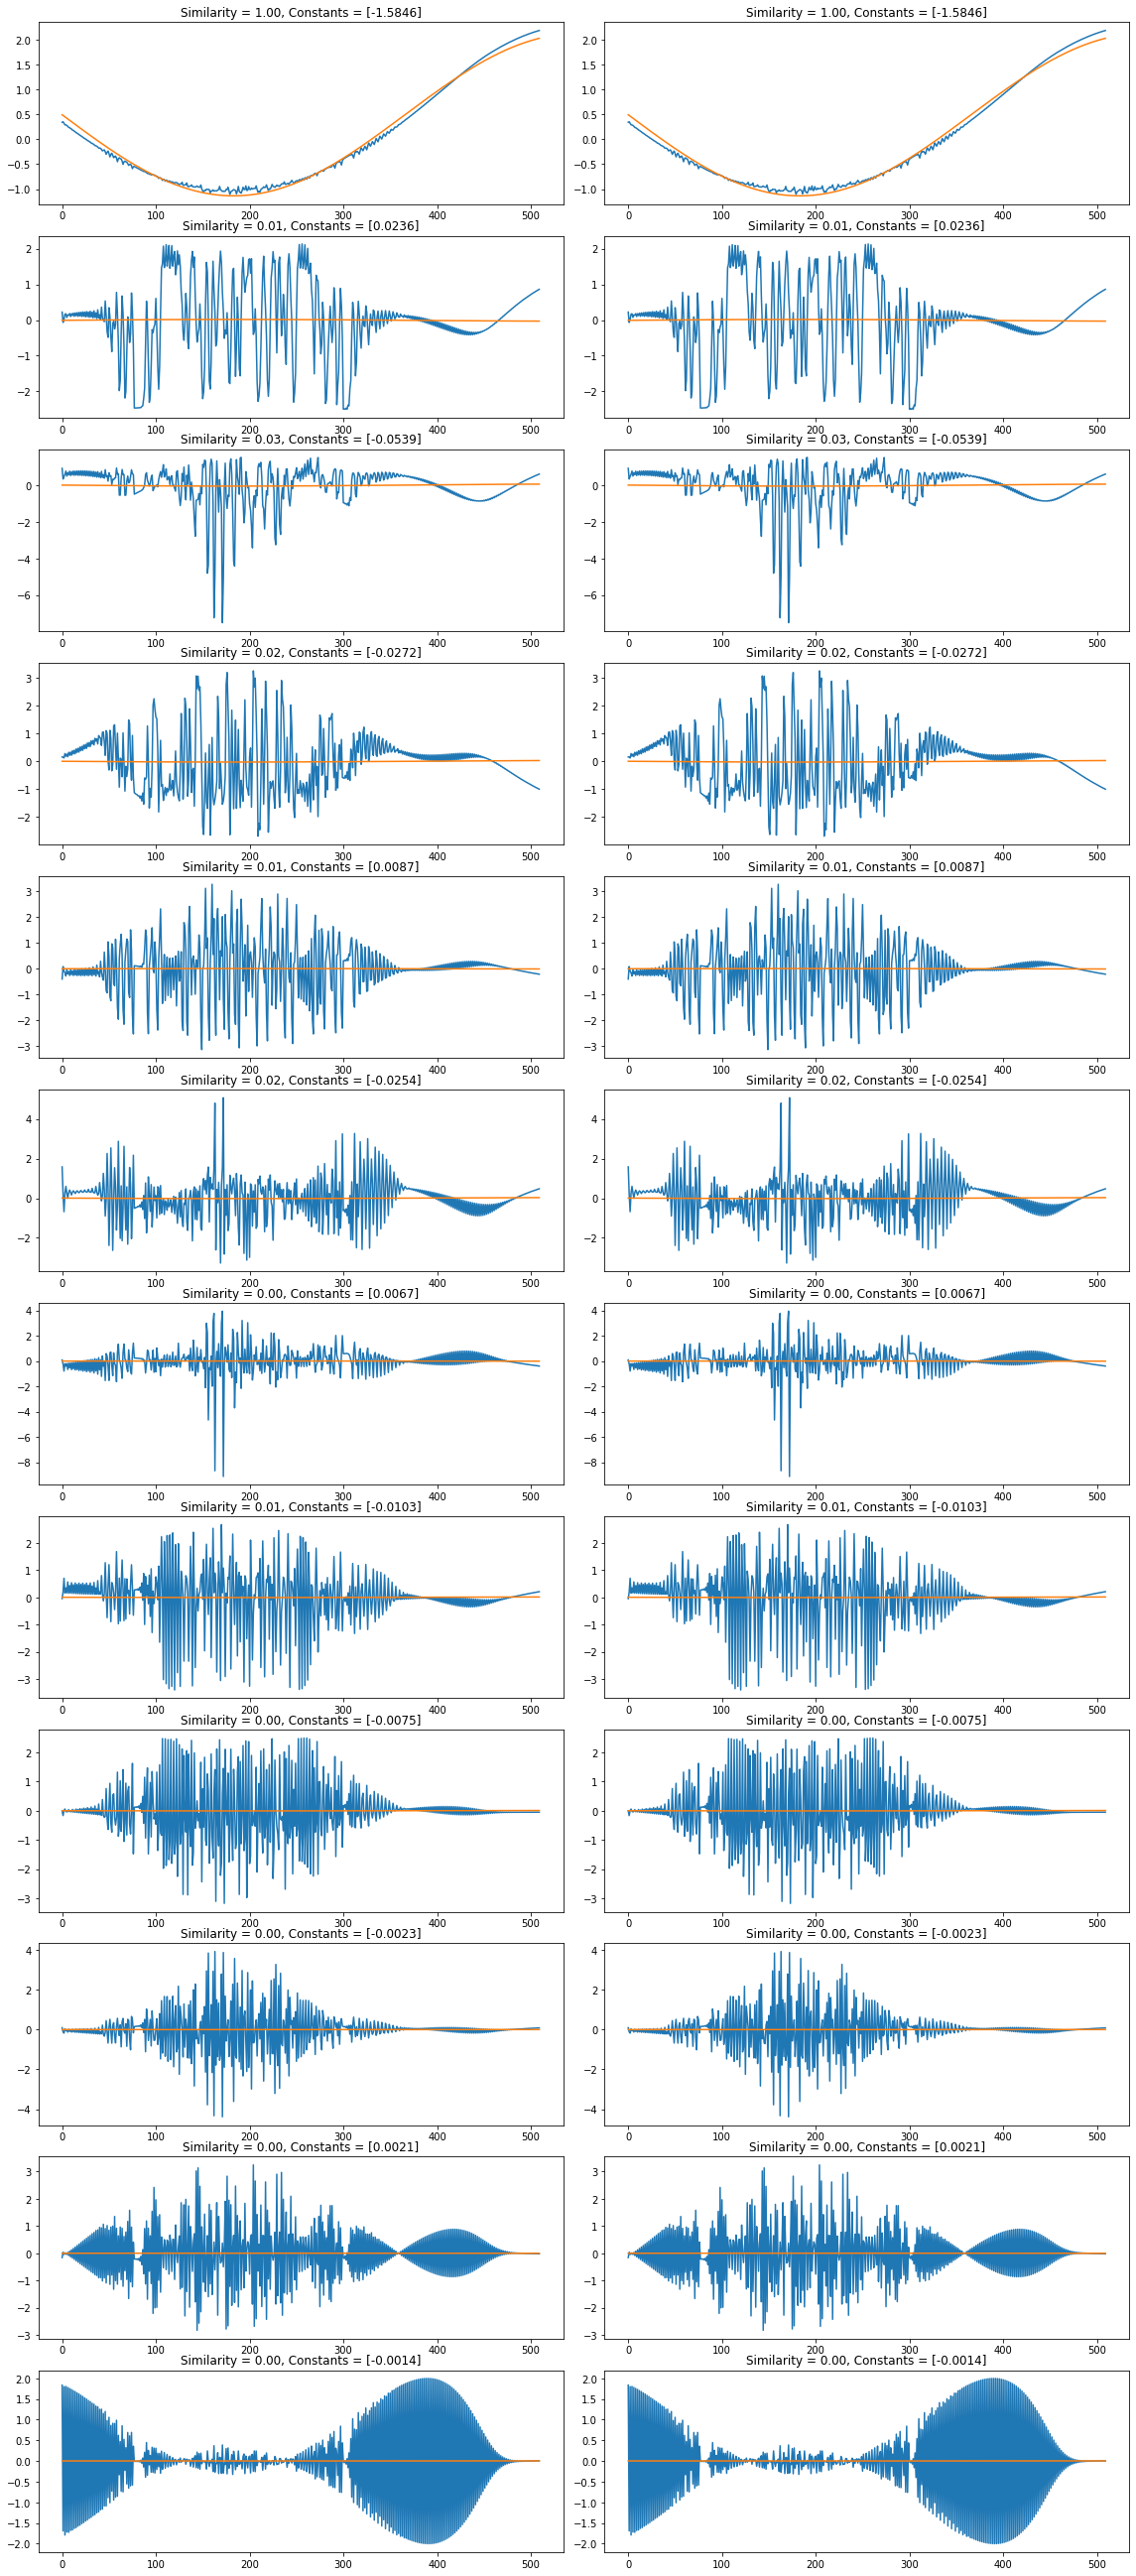

In [33]:
E = len(eigValDot)
cut = 1

if ndrivers == 1:
    gtsEmb = gtsr.reshape(gtsr.shape[0],1)
else:
    gtsEmb = gtsr[:X.shape[0]:cut,:]
gts = ( gtsEmb - np.mean(gtsEmb,axis=0) ) * 2 / np.ptp(gtsEmb,axis=0)

figLinComb, axLinComb = plt.subplots(E, ndrivers + 1,figsize=(16,E*3))
figLinComb.tight_layout()
for e in range(E):
    color = eigVecDot[:,e] @ z.T # color of SFA spectrum
    colorStnd = color - np.mean(color)
    
    for d in range(ndrivers):
        if ndrivers == 1:
            gtsSel = gts
        else:
            gtsSel = gts[:,d,None]
        gtsStnd = gtsSel - np.mean(gtsSel)
        k, sim = linearSimilarity(gtsStnd, colorStnd)
        lcomb = gtsStnd @ k
        # lcombStnd = lcomb - np.mean(lcomb)

        axLinComb[e,d].plot(colorStnd)
        axLinComb[e,d].plot(lcomb)
        axLinComb[e,d].set_title("Similarity = {:.2f}, Constants = {K}".format(sim, K = k))
        
    gtsStnd = gts - np.mean(gts, axis=0)
    k, sim = linearSimilarity(gtsStnd, colorStnd)
    lcomb = gtsStnd @ k
    
    axLinComb[e,ndrivers].plot(colorStnd)
    axLinComb[e,ndrivers].plot(lcomb)
    axLinComb[e,ndrivers].set_title("Similarity = {:.2f}, Constants = {K}".format(sim, K = k))
    
plt.show()

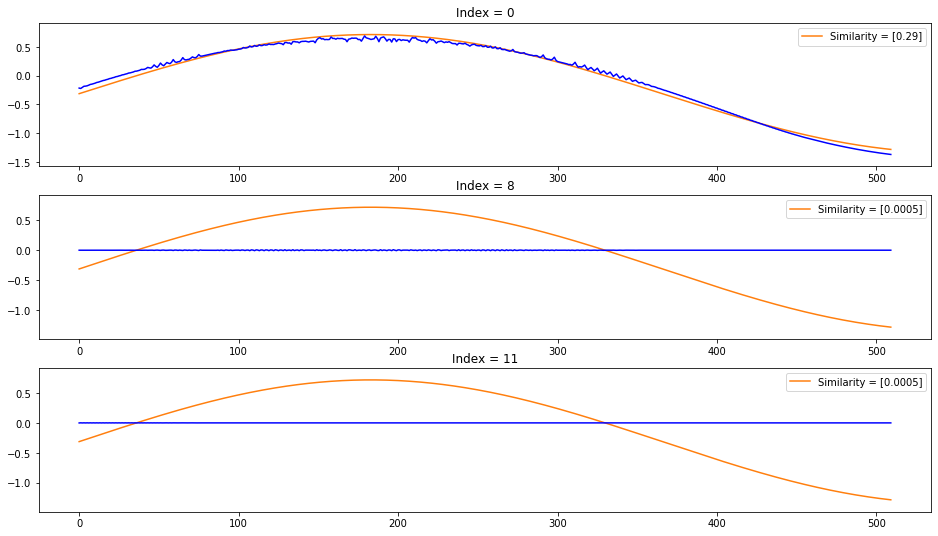

In [36]:
# cutoff = 5000

nVec = z.shape[1]
gtsStnd = ( gts - np.mean(gts,axis=0) ) * 2 / np.ptp(gts,axis=0)
# print(gtsStnd)

diffs = np.zeros((nVec,ndrivers))
for e in range(nVec):
    for d in range(ndrivers):
        ae = eigVecDot[:,np.argsort(eigValDot)[e]] @ z.T
        diffs[e,d] = timeSeriesSimilarity(gtsStnd[:,d], ae)

K = 3
figSim, axSim = plt.subplots(K ,ndrivers ,figsize=(16,K*3))
diffSrtd = np.flip(np.argsort(diffs,axis=0),axis=0)
# print('Differences = {d}'.format(d=diffs[diffSrtd]))
for d in range(ndrivers):
    for k in range(K):
        e = diffSrtd[k,d]

        # print(eigValDot.shape, eigVecDot.shape, z.T.shape)
        ae = eigVecDot[:,np.argsort(eigValDot)[e]] @ z.T
        aeStnd = ae - np.mean(ae)
        aeStnd = aeStnd / la.norm(aeStnd)
        delta = gtsStnd[:,d] @ aeStnd.T
        aeScld = aeStnd * delta

        # D = la.norm(gtsStnd - aeScld)

        if ndrivers == 1:
            axSim[k].margins(y=0.1)
            axSim[k].plot(gtsStnd[:,d],c="tab:orange")
            axSim[k].plot(aeScld[:],c="b")
            # axSim[k].legend("Diff = {dif}".format(dif=D), loc=1)
            axSim[k].set_title("Index = {ind}".format(ind=e))
            axSim[k].legend(["Similarity = {si}".format(si=diffs[e])])
            # axSim[k].legend(["MI = {mi}".format(mi=mutualInformation(X[:,0],aeScld,20))])
        else:
            axSim[k,d].margins(y=0.1)
            axSim[k,d].plot(gtsStnd[:,d],c="tab:orange")
            axSim[k,d].plot(aeScld[:],c="b")
            # axSim[k].legend("Diff = {dif}".format(dif=D), loc=1)
            axSim[k,d].set_title("Index = {ind}".format(ind=e))
            # axSim[k,d].legend(["MI = {mi}".format(mi=mutualInformation(X[:,0],aeScld,20))])

plt.subplots_adjust(hspace=0.2)
plt.show()

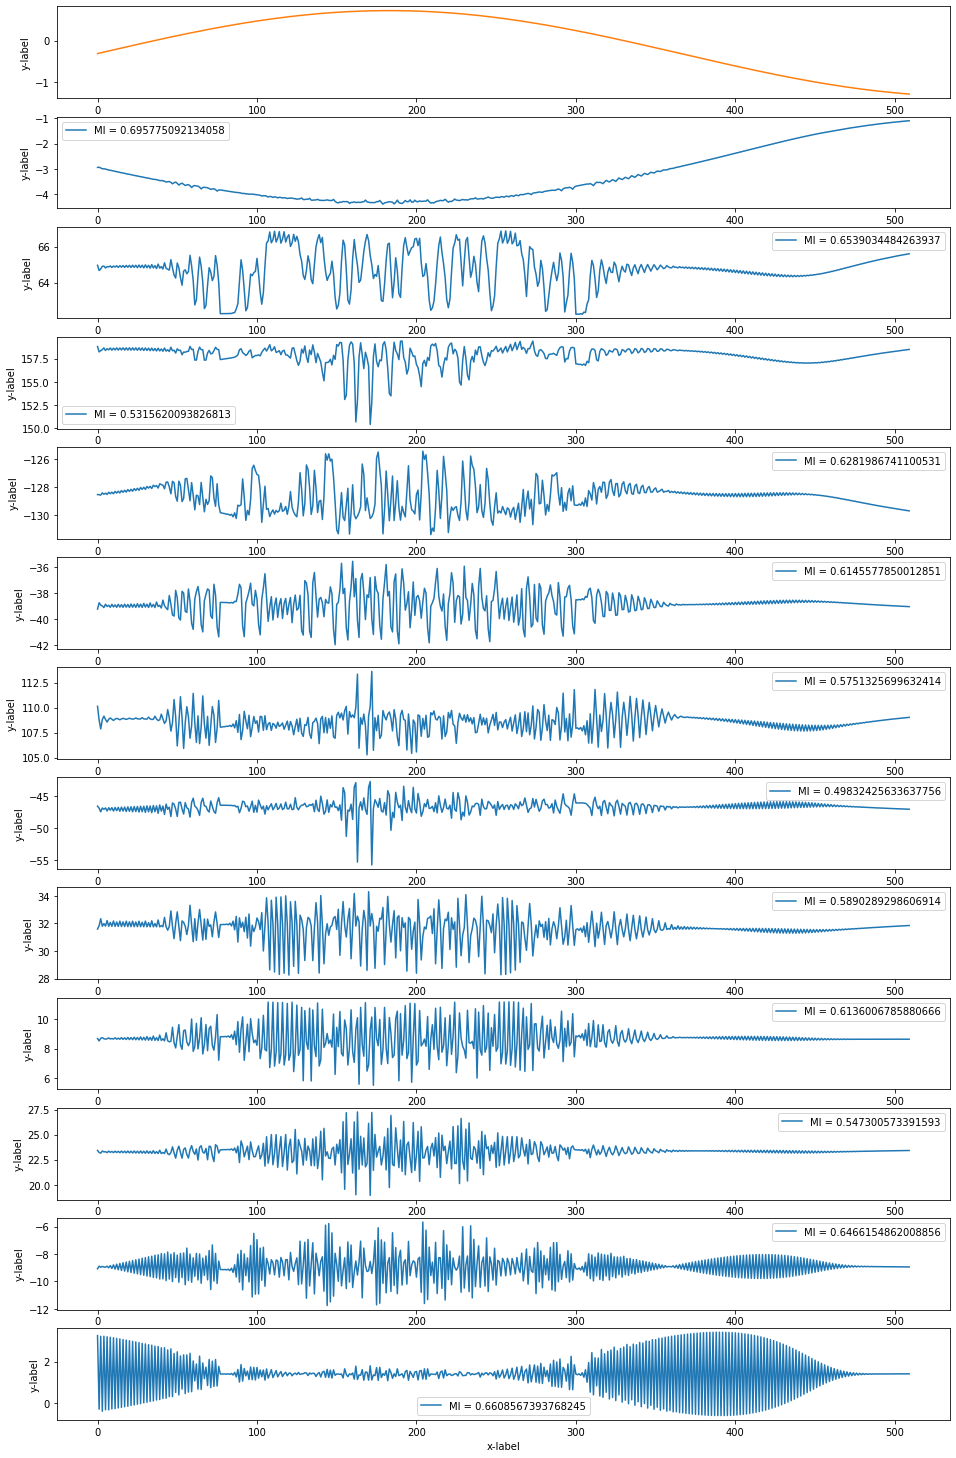

In [35]:
# gts = np.fromfunction(lambda i : r(i), yt.shape, dtype = float)# time series of gmax

# gts = np.fromfunction(lambda i : Gmax(i), yt.shape, dtype = float)# time series of gmax
# gts = np.fromfunction(lambda i : rho(i), yt.shape , dtype = float)# time series of gmax

cutoff = 5000
E = len(eigValDot)
fig, axs = plt.subplots(E+1,figsize=(16,(E+1)*2))
axs[0].plot(gts[:cutoff], c="tab:orange")

# print(ae.shape, z.T.shape)
for e in range(E):
    ae = eigVecDot[:,np.argsort(eigValDot)[e]]
    color = ae @ z.T
    axs[e+1].plot(color[:cutoff])
    axs[e+1].legend(["MI = {mi}".format(mi=mutualInformation(X[:,1],color,200))])

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# plt.plot(yt)

"""
# Zoom in on two
specInd = 4
figZ, axZ = plt.subplots(2, figsize=(16,6))
axZ[0].plot(gts[:200,], c="tab:orange")
ae = eigVecDot[:,np.argsort(eigValDot)[specInd]]
axZ[1].plot((ae @ z.T)[:200,])
"""

plt.show()

[[1.  0.1 0.9]
 [0.1 1.  0.2]
 [0.9 0.2 1. ]]
Eigenvalues  [0.0943 0.9581 1.9476]
Eigenvectors 
 [[-0.6982  0.2115 -0.684 ]
 [-0.08   -0.9724 -0.219 ]
 [ 0.7115  0.0982 -0.6958]]
[[-0.0659  0.2026 -1.3321]
 [-0.0075 -0.9316 -0.4266]
 [ 0.0671  0.0941 -1.3552]] [-0.0659 -0.0075  0.0671]


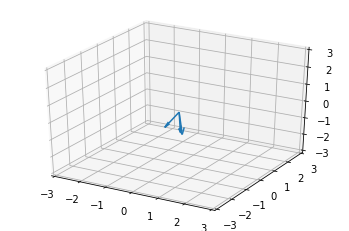

In [58]:
expCov = np.array([[1, 0.1, 0.9],[0.1, 1, 0.2],[0.9, 0.2, 1]])
print(expCov)
expVal, expVec = la.eigh(expCov)
print("Eigenvalues ", expVal)
print("Eigenvectors \n", expVec)

scaledVec = expVec * expVal
print(scaledVec, scaledVec[:,0])

covAx = plt.figure().add_subplot(projection="3d")
covAx.axes.set_xlim3d(left=-3,right=3)
covAx.axes.set_ylim3d(bottom=-3,top=3)
covAx.axes.set_zlim3d(bottom=-3,top=3)
covAx.quiver(np.zeros((3)),np.zeros((3)),np.zeros((3)), scaledVec[:,0], scaledVec[:,1], scaledVec[:,2], normalize=False)
plt.show()

In [59]:
A = np.array([[1,2,0],[2,1,0],[0,0,1]])
Ainv = la.inv(A)
d = np.array([1,1,76])
print(A @ Ainv)
print(Ainv @ A)

B = np.array([[1,2],[2,1],[0,0]])
print(B.shape)
Binv = np.identity(3)
print(Binv)
Binv[:,:2] = B[:,:2]
Binv = la.inv(Binv)
print(Binv)
# Binv = B.T @ la.inv(B @ B.T)
print(Binv.shape)
print(d @ Binv)

print(B.shape, d.shape)
print(linearSimilarity(B, d))

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(3, 2)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[-0.3333  0.6667  0.    ]
 [ 0.6667 -0.3333  0.    ]
 [ 0.      0.      1.    ]]
(3, 3)
[ 0.3333  0.3333 76.    ]
(3, 2) (3,)
(array([0.3333, 0.3333]), 0.01860485240619825)


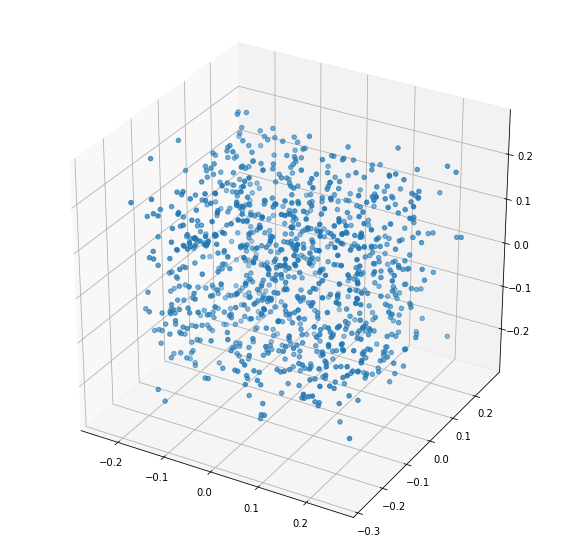

In [82]:
figNLDR = plt.figure(1,figsize=(10,10))
axNLDR = figNLDR.gca(projection="3d")
# axNLDR.scatter(zdot[:,0],zdot[:,1],zdot[:,2])
axNLDR.scatter(X_transformed[:,0],X_transformed[:,1],X_transformed[:,2])
plt.show()

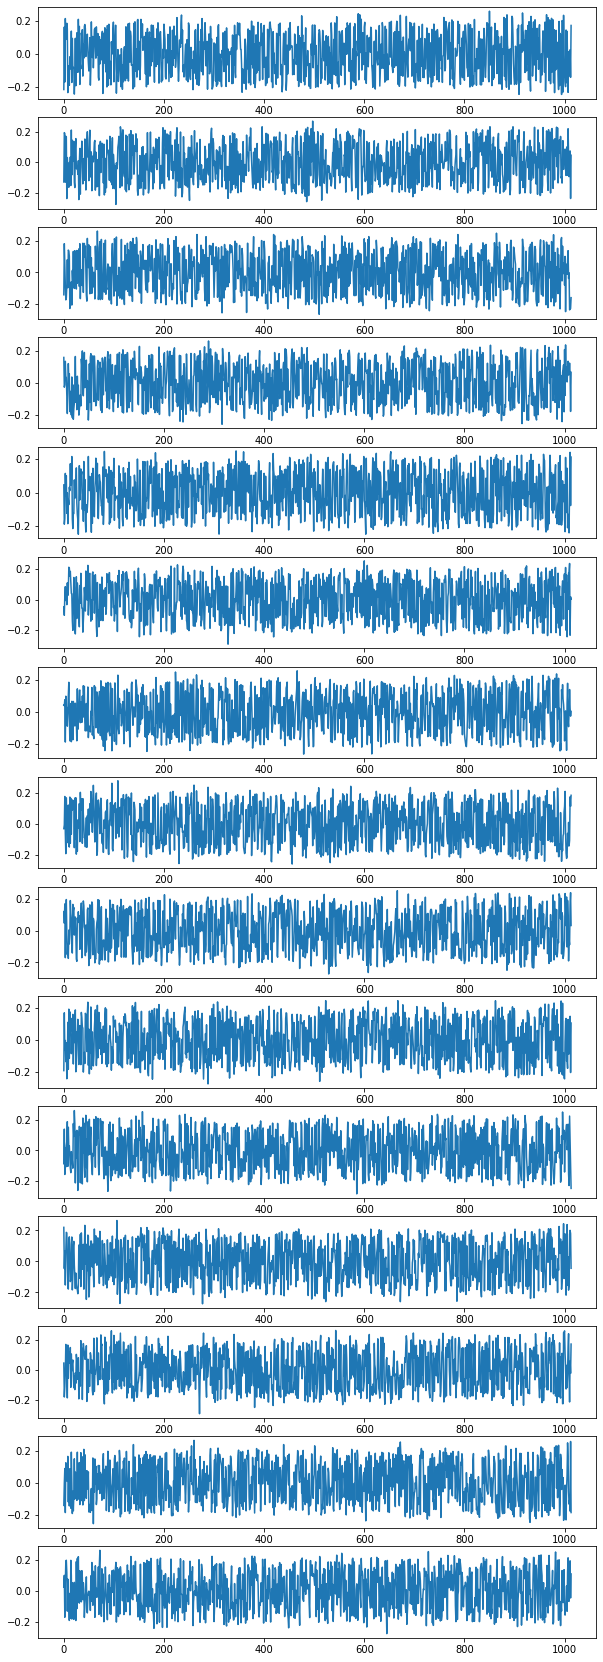

In [83]:
nDims = 15
figNLSFA, axNLSFA = plt.subplots(nDims,figsize=(10,2*nDims))
for i in range(nDims):
    axNLSFA[i].plot(X_transformed[:,i])
    
plt.show()